## **Construction d'un algorithme de prédiction du nombre d'observations pour les mois à venir**

Données extaites du site iNaturalist.org : https://www.inaturalist.org/pages/developers - http://www.inaturalist.org/observations/gbif-observations-dwca.zip

### But de cet algorithme : 

Déterminer à l'avance le nombre d'observations globales sur le site d'iNaturalist pour les 18 mois suivants.
Cela peut premettre d'anticiper les pré-requis techniques en fonction de la charge attendue sur le site.

Appliqué à une espèce en particulier, cela peut également permettre de constater si des observations d'une espèce ne sont pas au niveau attendu, et rechercher une explication (exemples, au niveau du site, moins populaire dans cette partie du globe / au niveau de l'espèce, moins observable cette année ou dont la population diminue, etc etc...)

1er traitement des données fait sur KNIME (data preparation) :

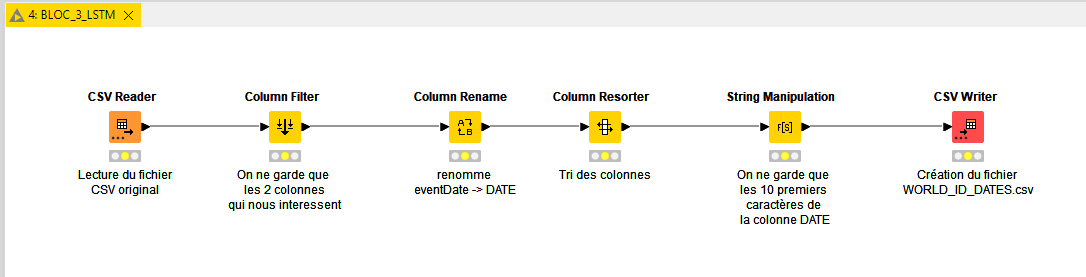

## 1. Imports bibliothèques python

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import r2_score


## 2. Import, compréhension et transformation des données
Data preparation

Import du fichier généré via KNIME avec 2 colonnes : DATE et id

In [2]:
df = pd.read_csv('WORLD_ID_DATES.csv') 

A quoi ressemble notre dataset ?

Un index de 0 à 68755814, une colonne DATE au format AAAA-MM-JJ et une colonne id

In [3]:
print(df)

                DATE         id
0         2022-08-31  133060946
1         2022-08-24  133060959
2         2022-08-31  133060960
3         2022-08-31  133060970
4         2022-08-31  133060971
...              ...        ...
68755810  2019-04-06   22176809
68755811  2019-04-04   22176815
68755812  2019-04-05   22176817
68755813  2019-04-07   22176823
68755814  2017-05-20   22176824

[68755815 rows x 2 columns]


Je vérifie que tous les id sont bien uniques

In [4]:
df['id'].nunique()

68755815

C'est bien le cas, on a autant d'id uniques que de lignes dans le dataframe Pandas.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68755815 entries, 0 to 68755814
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   DATE    object
 1   id      int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ GB


On sait, car il est précisé dans la sources des données, que ces données sont de type "grade Recherche", qui est un indicateur de qualité tenu par le site iNaturalist, et on peut donc les considérer fiables.
Il ne faut déterminer que la plage de dates à prendre en compte pour pouvoir créer cet algorithme avec fiabilité

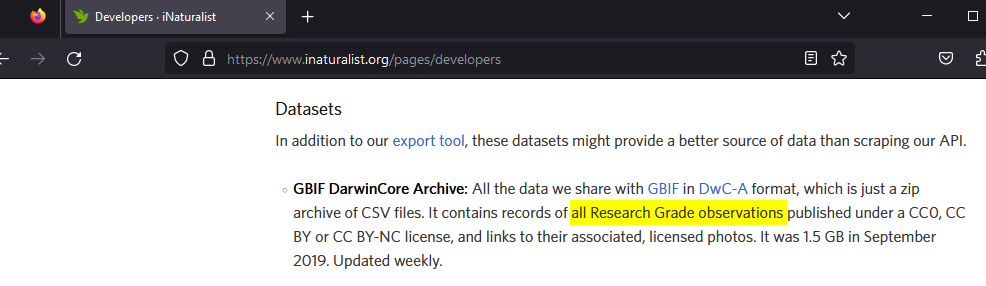

Première représentation graphique des données 

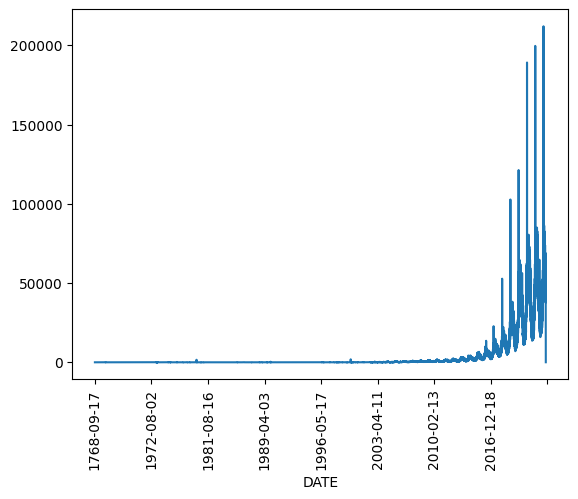

In [6]:

df_graph = df.groupby(['DATE'])['id'].count()
fig, ax = plt.subplots()
df_graph.plot(ax=ax)

plt.xticks(rotation=90)

plt.show()

Au vu du graph, j'enlève toutes les valeurs abhérentes ou très peu significatives avant les années 2000.
Et je le regarde de nouveau graphiquement

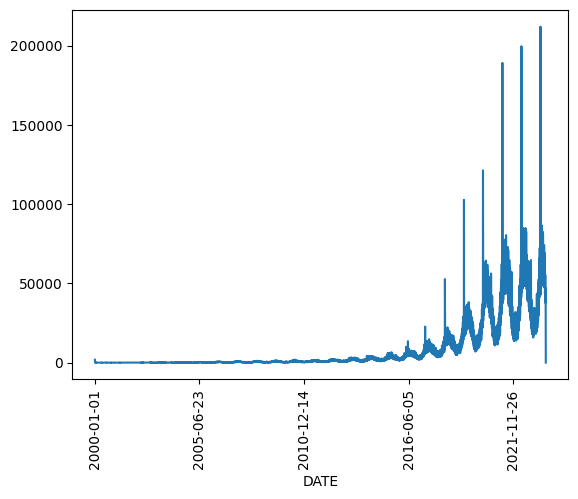

In [7]:
df_recherches_dates = df.loc[df['DATE'] >= '2000-01-01']
df_recherches_dates_graph = df_recherches_dates.groupby(['DATE'])['id'].count()
fig, ax = plt.subplots()

df_recherches_dates_graph.plot(ax=ax)

plt.xticks(rotation=90)

plt.show()



J'affine ce que j'avais trouvé précédemment : je décide de prendre les données à partir de l'année 2017.

#Les données seront regroupées par mois. Comme j'ai téléchargé le dataset au mois d'août, il n'est pas #complet pour le mois d'août 2023. Je décide d'arrêter les données au 31/07/2023 et réaffiche le graph après ces sélections de données.

In [8]:
df = df.loc[df['DATE'] >= '2017-01-01']
df = df.loc[df['DATE'] <= '2023-07-31']

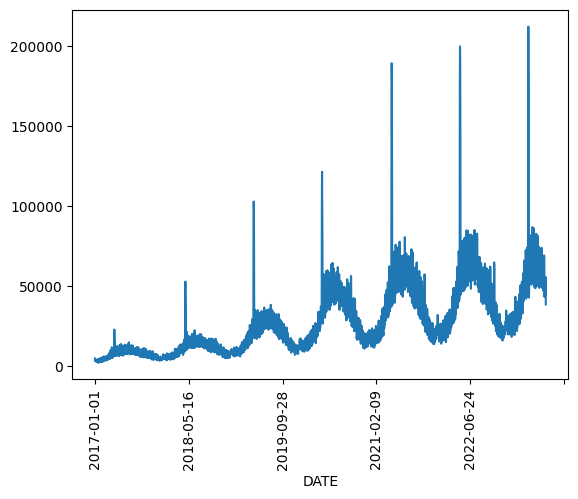

In [9]:
df_graph = df.groupby(['DATE'])['id'].count()
fig, ax = plt.subplots()

df_graph.plot(ax=ax)
plt.xticks(rotation=90)

plt.show()

Tri des données du dataset

In [10]:
df.sort_values("DATE",inplace=True)

Pour pouvoir exploiter les données par mois et prédire le nombre d'observations sur les mois suivants, je ne garde qu'une date, le 1er du mois, pour toutes les données du mois en cours.

Par ex, une observation faite le 06/05/2023 aura après le traitement une date de 01/05/2023 

In [11]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['DATE'] = df['DATE'].dt.to_period('M').dt.to_timestamp()

Maintenant que toutes les dates du mois sont regroupées sous une date unique, je peux compter le nombre d'occurence d'observations par mois et réafficher le dataframe pour constater les modifications.

In [12]:
df = df.groupby(['DATE'])['id'].count()

In [13]:
print(df)

DATE
2017-01-01     101635
2017-02-01     108537
2017-03-01     163040
2017-04-01     282262
2017-05-01     262845
               ...   
2023-03-01    1068408
2023-04-01    1980261
2023-05-01    1994896
2023-06-01    1776404
2023-07-01    1679274
Name: id, Length: 79, dtype: int64


Le dataframe est maintenant une Series Pandas. Je le re transforme en dataframe et renomme la colonne 'id' en 'nb' pour mieux refléter son contenu

In [14]:
print("Avant transformation en DataFrame : ", type(df))

df = pd.DataFrame(df)

print("Après transformation en DataFrame : ", type(df))

df.rename(columns={'id':'nb'}, inplace=True)

Avant transformation en DataFrame :  <class 'pandas.core.series.Series'>
Après transformation en DataFrame :  <class 'pandas.core.frame.DataFrame'>


Visualisation du Dataframe df :

On remarque que la colonne DATE est maintenant en index du dataframe suites aux transformations.

C'est bien ce que l'on recherche pour la suite de l'exploitation des données.

In [15]:
df

,nb
DATE,
2017-01-01,101635
2017-02-01,108537
2017-03-01,163040
2017-04-01,282262
2017-05-01,262845
...,...
2023-03-01,1068408
2023-04-01,1980261
2023-05-01,1994896


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 2017-01-01 to 2023-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   nb      79 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB


Affichage graphique des données du dataframe après modifications

In [17]:
fig = px.line(df, x=df.index , y='nb')

fig.update_layout(yaxis_title="Nbre d'observations (millions)")

fig.show()


## 3. Split des données en données d'entraînement et données de test

On considère que les 18 derniers mois constitueront nos données de test et celles d'avant seront nos données d'entraînement

In [19]:
test_len = 18 

ind = len(df) - test_len
train = df[:ind] #train : toutes les données sauf les 18 derniers mois
test = df[ind:] #test : les 18 derniers mois

print(f'Longueur du dataset train : {len(train)}')
print(f'Longueur du dataset test : {len(test)}')


Longueur du dataset train : 61
Longueur du dataset test : 18


Aperçu de notre ensemble de test ?

In [20]:
test

,nb
DATE,
2022-02-01,621670
2022-03-01,908245
2022-04-01,1616383
2022-05-01,1990985
2022-06-01,1847225
2022-07-01,1989173
2022-08-01,1603900
2022-09-01,1353370
2022-10-01,1239722


Mise à l'échelle des données test et train avec MinMaxScaler()

In [21]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

La mise à l'échelle des données transforme les données en nombre décimaux entre 0 et 1 pour une facilité de traitement.
Il faudra donc faire l'opération inverse après traitement.

La mise à l'échelle s'est faite avec les données train_sc, puis appliquée également sur les données test_sc.
C'est pour cela qu'on peut trouver des données supérieures à 1 dans test_sc (pour les données plus grandes que la max des données présente dans train)

In [22]:
test_sc

array([[0.28173154],
       [0.43698496],
       [0.82062223],
       [1.02356472],
       [0.94568202],
       [1.02258306],
       [0.8138595 ],
       [0.67813363],
       [0.61656427],
       [0.36561633],
       [0.30538564],
       [0.35330657],
       [0.34543   ],
       [0.52375406],
       [1.01775493],
       [1.02568352],
       [0.9073144 ],
       [0.85469374]])

## 4. Construire train et test generators

Comme on a ici une seule série, qui sera à la fois les données de départ (sur 12 mois, X) et la résultante (le mois suivant, y), il faut construire pour les 2 datasets de données, 

In [23]:
#on prend 12 données (sequence_length) pour prédire la prochaine donnée (out_len))

sequence_length = 12 
out_len = 1

# Train Generator
train_gen = TimeseriesGenerator(data = train_sc,
                                targets = train_sc,
                                length = sequence_length,
                                batch_size = out_len)

# Test Generator
test_gen = TimeseriesGenerator(data = test_sc,
                                targets = test_sc,
                                length = sequence_length,
                                batch_size = out_len)

In [24]:
print(f'Length of Train set: {len(train)}')
print(f'Length of Train Generator:{len(train_gen)}')

print(f'Length of Test set: {len(test)}')
print(f'Length of Test Generator:{len(test_gen)}')

Length of Train set: 61
Length of Train Generator:49
Length of Test set: 18
Length of Test Generator:6


Explication des données obtenues suite à l'utilisation de TimeseriesGenerator : les 12 données de X dans l'exemple ici permettront de prédire la données y du mois suivant. Puis l'opération se décale d'un mois en reprenant le mois prédit précédemment parmis les 12 derniers mois.

In [25]:
X, y = train_gen[0] # First gen object

print(f'First train_gen object input (X): {len(X[0])}\n {X}\n') 
print(f'First train_gen object output (y): {len(y[0])}\n {y}') 

First train_gen object input (X): 12
 [[[0.        ]
  [0.00373919]
  [0.03326646]
  [0.09785557]
  [0.08733632]
  [0.09205879]
  [0.10545802]
  [0.08241176]
  [0.06736398]
  [0.05087458]
  [0.0312533 ]
  [0.02322774]]]

First train_gen object output (y): 1
 [[0.03162115]]


## 5. Construction du modèle LSTM

In [26]:
# Construction du modèle LSTM
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(sequence_length, 1)))

#ajout d'une couche de droput pour éviter l'overfitting :
model.add(Dropout(0.30)) 

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

Entraînement du modèle

In [27]:
model.fit(train_gen, validation_data=test_gen, epochs=100)

Epoch 1/100
49/49 [==============================] - 1s 7ms/step - loss: 0.0717 - val_loss: 0.0954
Epoch 2/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0400 - val_loss: 0.0722
Epoch 3/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0422 - val_loss: 0.1164
Epoch 4/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0384 - val_loss: 0.0418
Epoch 5/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0310
Epoch 6/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0292 - val_loss: 0.0256
Epoch 7/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.2358
Epoch 8/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0390 - val_loss: 0.0253
Epoch 9/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.0999
Epoch 10/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0321 - val_loss: 0.0375
Epoch 11/

Récapitulation des informations du modèle

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


### Utilisation du modèle pour générer les prédictions sur les mêmes données que le "test"

In [29]:
# Liste vide pour stocker les prédictions :
y_pred = [] 

# 12 dernières données d'entraînement pour prédire la suivante :
train_sc_lastrows = train_sc[-sequence_length:] 

# Reshape (1, 12, 1)
batch = train_sc_lastrows.reshape((1, sequence_length, 1)) 

for _ in range(len(test)): 
  pred = model.predict(batch) #Prédiction
  y_pred.append(pred[0]) # Ajout de la prédiction à la liste
  batch = np.append(batch[:,1:,:],[pred],axis=1) # On enlève le premier element de 'batch', on ajoute notre nouvelle prédiction à la fin, et on refait une prochaine prédiction.

1/1 [==============================] - 0s 22ms/step


Prédictions réalisées dans l'array y_pred :

In [30]:
y_pred

[array([0.32032037], dtype=float32),
 array([0.59601074], dtype=float32),
 array([0.86049724], dtype=float32),
 array([0.9920997], dtype=float32),
 array([0.99335635], dtype=float32),
 array([0.9618952], dtype=float32),
 array([0.8630083], dtype=float32),
 array([0.7465078], dtype=float32),
 array([0.60566455], dtype=float32),
 array([0.4369076], dtype=float32),
 array([0.35898176], dtype=float32),
 array([0.33475554], dtype=float32),
 array([0.4457122], dtype=float32),
 array([0.70298916], dtype=float32),
 array([0.9156579], dtype=float32),
 array([1.0164821], dtype=float32),
 array([1.0275528], dtype=float32),
 array([0.9805387], dtype=float32)]

Remise à l'échelle de départ et ajout des prédictions à notre dataset test de départ :

In [31]:
# On enlève la mise à l'échelle -> revenir à nos données de départ
y_pred = sc.inverse_transform(y_pred) 

#Ajout des prdiction à notre data set test de départ pour comparaison :
test['y_pred'] = y_pred 

C:\Users\Pauline\AppData\Local\Temp\ipykernel_13012\3383274075.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['y_pred'] = y_pred


Visualisation ensemble "test" après ajout y_pred :

In [32]:
test

,nb,y_pred
DATE,,
2022-02-01,621670,6.928993e+05
2022-03-01,908245,1.201783e+06
2022-04-01,1616383,1.689986e+06
2022-05-01,1990985,1.932905e+06
2022-06-01,1847225,1.935225e+06
2022-07-01,1989173,1.877152e+06
2022-08-01,1603900,1.694621e+06
2022-09-01,1353370,1.479579e+06
2022-10-01,1239722,1.219603e+06


Visualisation graphique de nos prédictions par rapport à nos données réelles :

<Axes: xlabel='DATE'>

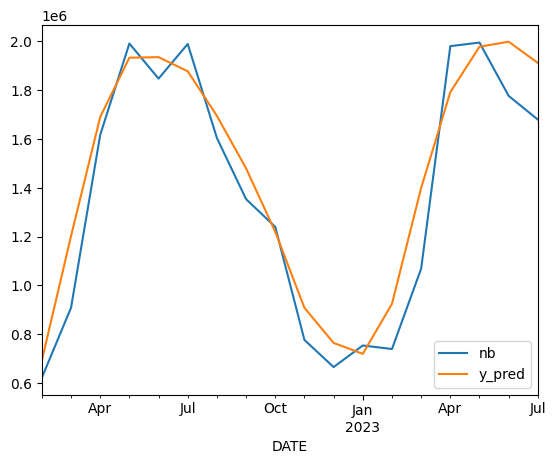

In [33]:
test.plot() 

### Calcul des indicateurs de performance du modèle :

In [47]:
rmse = mean_squared_error(test['nb'],test['y_pred'])**0.5
df_mean = df['nb'].mean()
print(f'RMSE : {rmse}')
print(f'Scatter Index: {rmse/df_mean}')

r2 = r2_score(test['nb'], test['y_pred'])
print(f'R-squared : {r2}')

RMSE : 159147.81388826208
Scatter Index: 0.200149710941929
R-squared : 0.9018185945917903


- **RMSE (Root Mean Squared Error)** :

RMSE est une mesure de l'erreur moyenne entre les valeurs prédites par le modèle (y_pred) et les valeurs réelles (test['nb']).
Dans ce cas, le RMSE est d'environ 159,147.81, ce qui signifie que, en moyenne, les prédictions du modèle diffèrent d'environ 159,147.81 unités par rapport aux valeurs réelles.
Un RMSE plus faible indique une meilleure précision. Le fait que le RMSE soit inférieur à la moyenne des données réelles est un indicateur positif, suggérant que le modèle a une certaine capacité à capturer les tendances dans les données.

- **Scatter Index : Le Scatter Index** :

Le Scatter Index est calculé en divisant le RMSE par la moyenne des données réelles.
Un Scatter Index plus faible indique une meilleure performance.
Ici, le Scatter Index est d'environ 0.200, ce qui signifie que l'erreur du modèle est d'environ 20 % de la moyenne des données réelles.
Un Scatter Index de 0.2 suggère que le modèle a une performance relativement bonne, car l'erreur est d'environ 20 % de la variation naturelle des données.

- **Coefficient de Détermination (R-squared)** :

Le R-squared mesure la proportion de la variance dans les données de réponse qui est expliquée par le modèle.
Un R-squared plus élevé indique un meilleur ajustement du modèle aux données.
Dans ce cas, le R-squared est d'environ 0.902, ce qui est excellent. Cela signifie que le modèle explique environ 90.2 % de la variance dans les données réelles.
Un R-squared aussi élevé suggère que le modèle LSTM est bien adapté aux données de test et peut prédire avec précision les valeurs futures.

## 6. Utilisation du modèle pour prédiction des 18 prochains mois

Mise à l'échelle du dataset

In [39]:
sc = MinMaxScaler()
df_sc = sc.fit_transform(df)

Aperçu de notre dataset mis à l'échelle :

In [40]:
df_sc

array([[0.        ],
       [0.00364556],
       [0.03243346],
       [0.09540523],
       [0.08514938],
       [0.08975361],
       [0.10281731],
       [0.08034814],
       [0.06567716],
       [0.04960066],
       [0.03047071],
       [0.02264611],
       [0.03082935],
       [0.02925006],
       [0.07438119],
       [0.18392657],
       [0.16851876],
       [0.17716258],
       [0.18595429],
       [0.15710195],
       [0.13664888],
       [0.11007938],
       [0.07145502],
       [0.06337267],
       [0.07865793],
       [0.07748483],
       [0.167071  ],
       [0.39454676],
       [0.32185631],
       [0.35958486],
       [0.4008919 ],
       [0.36092224],
       [0.28476845],
       [0.21979062],
       [0.13413576],
       [0.11566498],
       [0.14669874],
       [0.16292154],
       [0.25980676],
       [0.53075725],
       [0.64108277],
       [0.66519989],
       [0.69473094],
       [0.60265436],
       [0.53396653],
       [0.39301026],
       [0.25010128],
       [0.195

In [48]:
interval = 18
sequence_length = 12
forecast = []
sc_df_lastrows = df_sc[-sequence_length:]
batch1 = sc_df_lastrows.reshape((1, sequence_length, 1))

for _ in range(interval):
  pred1 = model.predict(batch1)
  forecast.append(pred1[0]) 
  batch1 = np.append(batch1[:,1:,:],[pred1],axis=1)

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Aperçu du dataset de prédictions :

In [49]:
forecast

[array([0.83768463], dtype=float32),
 array([0.75446427], dtype=float32),
 array([0.6382816], dtype=float32),
 array([0.47300163], dtype=float32),
 array([0.39585745], dtype=float32),
 array([0.37496492], dtype=float32),
 array([0.4719026], dtype=float32),
 array([0.7378016], dtype=float32),
 array([0.9549325], dtype=float32),
 array([0.99590236], dtype=float32),
 array([0.9627596], dtype=float32),
 array([0.921613], dtype=float32),
 array([0.8657823], dtype=float32),
 array([0.7760632], dtype=float32),
 array([0.6584302], dtype=float32),
 array([0.53167194], dtype=float32),
 array([0.44381332], dtype=float32),
 array([0.42854473], dtype=float32)]

Inversion de la mise à l'échelle :

In [50]:
forecast = sc.inverse_transform(forecast)

Création d'un nouveau dataframe avec les dates futures

In [51]:
fc_index = pd.date_range(start='2023-08-01', periods=interval, freq='MS')
fc_df = pd.DataFrame(forecast, index=fc_index, columns=['forecast'])

Visualisation graphique des prédictions du modèle :

<Axes: xlabel='DATE'>

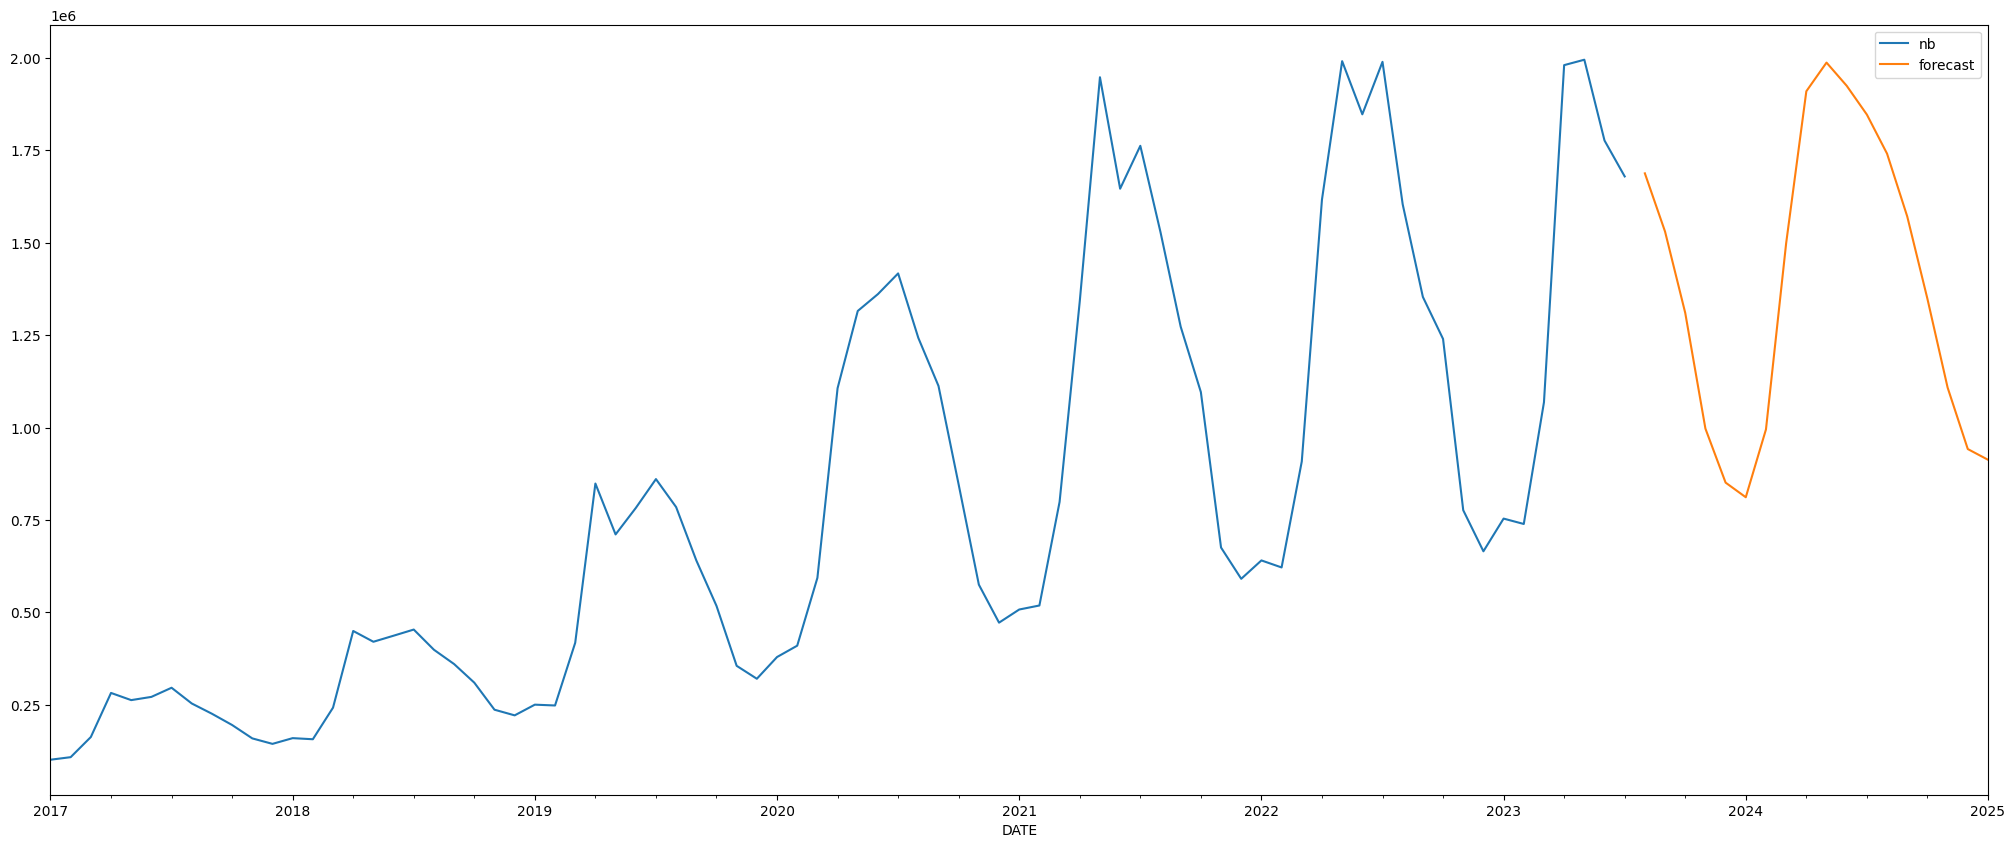

In [52]:
ax = df.plot()
fc_df.plot(ax=ax, figsize=(25,10))